## Import dependencies

In [1]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# stats
#import pycircstat as pyc
from scipy import stats

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from neuropop import NeuroPop
from neurovis import NeuroVis

# local
import V4pyutils

## Read in files

### List files

In [2]:
h5path = '../V4pydata/H5data/M3/'
fname = glob.glob(h5path+'/*89a*')
fname
glob.glob(h5path+'/*89a*')

['../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5_imagefeatures_wip',
 '../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev_imagefeatures_wip.h5',
 '../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5']

### Artificial

In [3]:
# Read using deepdish
art_file = fname[3]
print art_file
art_dat = dd.io.load(art_file)

../V4pydata/H5data/M3/Ro150212_289a_huecircle_0003_nev.h5


### Natural

In [4]:
# Read using deepdish
nat_file = fname[0]
print nat_file
nat_dat = dd.io.load(nat_file)

../V4pydata/H5data/M3/Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5


### Sanity check: compare firing rates for artificial vs. natural

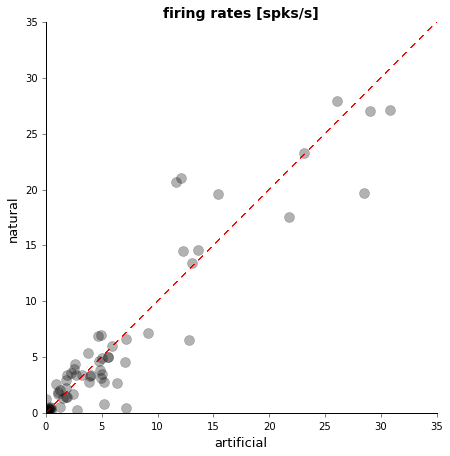

In [5]:
# Artificial
art_rates = dict()
for neuron_id in art_dat['spikes']:
    art_rates[neuron_id]=V4pyutils.get_firing_rate(art_dat['spikes'][neuron_id])

# Natural
nat_rates = dict()
for neuron_id in nat_dat['spikes']:
    nat_rates[neuron_id]=V4pyutils.get_firing_rate(nat_dat['spikes'][neuron_id])

# Plot artificial vs. natural firing rates
plt.figure(figsize=(7,7))
for i in art_rates:
    plt.plot([0,35],[0,35],'--r', lw=0.1)
    plt.plot(art_rates[i], nat_rates[i],'ko', alpha=0.3, ms=10)
    plt.xlabel('artificial')
    plt.ylabel('natural')
    plt.title('firing rates [spks/s]')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    plt.axis('equal')
plt.show()

## Explore data by visualizing PSTHs

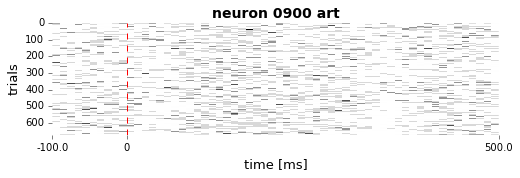

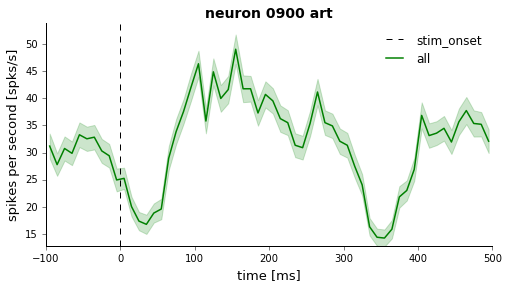

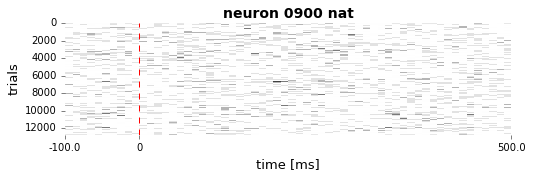

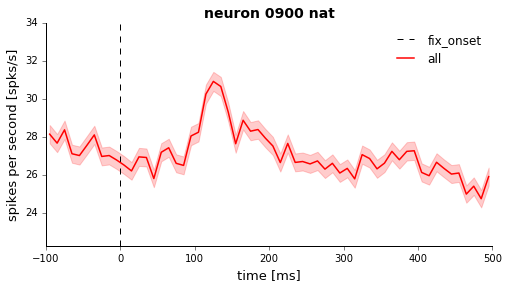

In [6]:
#neuron_id = '0700'
#neuron_id = '5801'
neuron_id = '0900'

art_neuron = NeuroVis(art_dat['spikes'][neuron_id], name='%s art' % neuron_id)
nat_neuron = NeuroVis(nat_dat['spikes'][neuron_id], name='%s nat' % neuron_id)

art_events = dict()
art_events['stim_onset'] = np.array([art_dat['eyes'][i]['stim_onset'] for i in art_dat['eyes']])
art_events['stim_offset'] = np.array([art_dat['eyes'][i]['stim_offset'] for i in art_dat['eyes']])

psth = art_neuron.get_raster(events=art_events['stim_onset']);
psth = art_neuron.get_psth(events=art_events['stim_onset'], plot=False);
art_neuron.plot_psth(psth=psth, event_name='stim_onset', colors='g');

nat_events = dict()
nat_events['fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in nat_dat['eyes']])
nat_events['fix_offset'] = np.array([nat_dat['eyes'][i]['fix_offset'] for i in nat_dat['eyes']])

psth = nat_neuron.get_raster(events=nat_events['fix_onset']);
psth = nat_neuron.get_psth(events=nat_events['fix_onset'], plot=False);
nat_neuron.plot_psth(psth=psth, event_name='fix_onset', colors='r');

#psth = nat_neuron.get_psth(events=nat_events['fix_offset'], plot=False);
#nat_neuron.plot_psth(psth=psth, event_name='fix_offset');

## Get features (X)

In [7]:
params = dict()
params['n_bins'] = 16 #number of bins of the histogram
params['window'] = [50, 300] #
params['radius'] = 200
params['n_patches'] = 16 #for natural stimuli
params['n_blocks'] = np.int(np.sqrt(params['n_patches']))
params['selected_neuron'] = '0900'
params['stimpath'] = '../V4pydata'

### artificial features

In [67]:
# Collect features of interest into a dict
features_art = dict()
features_art['col'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['row'] = np.array([art_dat['eyes'][i]['col'] for i in art_dat['eyes']])
features_art['hue'] = np.array([art_dat['features'][i]['hue'] for i in art_dat['features']])
features_art['onset_times'] = np.array([art_dat['events'][i]['onset'] for i in art_dat['events']])
features_art['offset_times'] = np.array([art_dat['events'][i]['offset'] for i in art_dat['events']])

features_art_df = pd.DataFrame.from_dict(features_art, orient='columns', dtype=None)

features_art_df['off_to_onset_times'] = features_art['onset_times']-np.roll(features_art['offset_times'],1)
features_art_df['off_to_onset_times'][0] = -999.0

features_art_df['hue_prev'] = np.roll(features_art['hue'], 1)
features_art_df['hue_prev'][0] = -999.0
features_art_df.head()

,col,hue,offset_times,onset_times,row,off_to_onset_times,hue_prev
0,368.0,1.822645,66.308333,66.106033,368.0,-999.000000,-999.000000
1,366.0,-0.131535,66.633233,66.435933,366.0,0.127600,1.822645
2,367.0,1.609290,66.947067,66.746033,367.0,0.112800,-0.131535
3,376.0,1.250616,67.272667,67.070933,376.0,0.123867,1.609290
4,366.0,3.125854,69.726167,69.508967,366.0,2.236300,1.250616


In [63]:
# Encode hue histogram as one-hot vector (sort of)
Xart = V4pyutils.onehothue(features_art_df['hue'], n_bins=params['n_bins'])
#Xart[:5]

### natural features

#### non-visual

In [64]:
for_features_nat = nat_dat['eyes'][0].keys()
for i in ['imname','impath']: for_features_nat.remove(i) 

features_nat = dict()
for feat in for_features_nat:
    features_nat[feat] = np.array([nat_dat['eyes'][fix][feat] for fix in nat_dat['eyes']]) 

In [74]:
features_nat_df = pd.DataFrame(features_nat)
features_nat_df['badfix'] = features_nat_df['badfix']==0
features_nat_df['in_sac_blink'] = features_nat_df['in_sac_blink']==1
features_nat_df['out_sac_blink'] = features_nat_df['out_sac_blink']==1

features_nat_df['fix_duration'] = features_nat_df['fix_offset'] - features_nat_df['fix_onset']
features_nat_df['next_fix_duration'] = np.append(features_nat_df['fix_duration'][1:], 0)
features_nat_df['prev_fix_duration'] = np.append(0, features_nat_df['fix_duration'][0:-1])
features_nat_df['in_screen'] = np.all((features_nat_df['col']>=1, features_nat_df['col']<=1024, \
                                features_nat_df['row']>=1, features_nat_df['row']<=768), axis=0)
features_nat_df['row_drift'] = features_nat_df['fix_offset_row']-features_nat_df['fix_onset_row']
features_nat_df['col_drift'] = features_nat_df['fix_offset_col']-features_nat_df['fix_onset_col']
features_nat_df['drift'] = np.sqrt(features_nat_df['row_drift']**2+features_nat_df['col_drift']**2)

features_nat_df.head()

,badfix,col,fix_offset,fix_offset_col,fix_offset_row,fix_onset,fix_onset_col,fix_onset_row,fixation,in_sac_blink,...,out_sac_pkvel,row,trial,fix_duration,next_fix_duration,prev_fix_duration,in_screen,row_drift,col_drift,drift
0,False,432.0,2.557,440.0,240.0,2.230,419.0,259.0,1,False,...,12.813501,250.0,1,0.327,0.183,0.000,True,-19.0,21.0,28.319605
1,True,447.0,2.779,446.0,324.0,2.596,445.0,316.0,2,False,...,138.809992,326.0,1,0.183,0.113,0.327,True,8.0,1.0,8.062258
2,True,162.0,2.945,163.0,500.0,2.832,163.0,500.0,3,False,...,123.457646,502.0,1,0.113,0.831,0.183,True,0.0,0.0,0.000000
3,False,-48.0,3.826,-64.0,273.0,2.995,-25.0,283.0,4,False,...,134.045849,273.0,1,0.831,0.173,0.113,False,-10.0,-39.0,40.261644
4,True,113.0,4.056,115.0,-17.0,3.883,105.0,-9.0,5,False,...,214.297960,-16.0,1,0.173,0.194,0.831,False,-8.0,10.0,12.806248


#### visual

In [12]:
# Extract a patch of arbitrary radius around a fixation and compute hue histograms

stimpath = params['stimpath']
R = params['radius']
n_patches = params['n_patches']
n_blocks = params['n_blocks']

# List of included fixations
fixation_list = list()

# Dictionaries for real and shuffled control features
Xnat = dict()
Xnat_shuf = dict()

#Grid patches
for grd in np.arange(n_patches): 
    Xnat[grd] = []
    Xnat_shuf[grd] = []

for fx in range(len(nat_dat['eyes'])):
    if fx%1000==0:
        print fx

    # Read in the image and shuffle image
    if (fx > 0 and nat_dat['eyes'][fx]['imname'] != nat_dat['eyes'][fx-1]['imname']) or fx == 0:
        I = V4pyutils.get_image(nat_dat['eyes'][fx], stimpath)
        fx_rnd = np.random.randint(low=0, high=len(nat_dat['eyes']), size=1)[0]
        Ishuf = V4pyutils.get_image(nat_dat['eyes'][fx_rnd], stimpath)

    # Get gaze location
    r = nat_dat['eyes'][fx]['row']
    c = nat_dat['eyes'][fx]['col']
    
    #If gaze is within the image borders
    if (nat_dat['eyes'][fx]['row'] > R) and \
        (nat_dat['eyes'][fx]['row'] < (768 - R)) and \
        (nat_dat['eyes'][fx]['col'] > R) and \
        (nat_dat['eyes'][fx]['col'] < (1024 - R)) \
        and (not np.isnan(r)) and (not np.isnan(c)):
        
        r = int(r)
        c = int(c)
        
        # Extract patches
        G = I[r-R:r+R, c-R:c+R, :]
        Gshuf = Ishuf[r-R:r+R, c-R:c+R, :]
        
        # Divide it into grids    
        G_block = V4pyutils.grid_image(G, [n_blocks, n_blocks])
        for grd in range(0, n_patches):
            hue = V4pyutils.get_hue_image(G_block[grd,:,:,:])
            Xnat[grd].append(V4pyutils.bin_it(hue, params))
        
        
        Gshuf_block = V4pyutils.grid_image(Gshuf, [n_blocks, n_blocks])
        for grd in range(0, n_patches):
            hue = V4pyutils.get_hue_image(Gshuf_block[grd,:,:,:])
            Xnat_shuf[grd].append(V4pyutils.bin_it(hue, params))

        fixation_list.append(fx)
        
    #else:
        #print r,c
        #print 'outside'

for grd in range(0, 16):
    Xnat[grd] = np.array(Xnat[grd])
    Xnat_shuf[grd] = np.array(Xnat_shuf[grd])

0


KeyboardInterrupt: 

In [ ]:
#dd.io.save('Xnat.h5', Xnat)
#dd.io.save('Xnat_shuf.h5', Xnat_shuf)
#dd.io.save('fixation_list.h5', fixation_list)

In [12]:
fixation_list = dd.io.load('fixation_list.h5')
Xnat = dd.io.load('Xnat.h5')
Xnat_shuf = dd.io.load('Xnat_shuf.h5')

In [13]:
Xnat_idx = dict()
for i in Xnat:
    Xnat_idx['bin_%s' % str(i)]=Xnat[i][0]
Xnat_idx

features_nat_img_df = pd.DataFrame(Xnat_idx)
features_nat_img_df.head()

,bin_0,bin_1,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9
0,0.0005,0.0000,0.0012,0.0009,0.0309,0.0097,0.0081,0.0041,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0037,0.0021
1,0.0035,0.0003,0.0170,0.0001,0.0927,0.0328,0.0370,0.0193,0.0012,0.0000,0.0192,0.0101,0.0129,0.0060,0.1647,0.0360
2,0.7733,0.9243,0.0635,0.0049,0.3056,0.5245,0.6239,0.5112,0.8261,0.9568,0.9154,0.9514,0.4051,0.1853,0.5164,0.2168
3,0.0624,0.0754,0.0306,0.0236,0.0426,0.0211,0.0725,0.0944,0.1714,0.0432,0.0436,0.0274,0.1041,0.1371,0.0863,0.1392
4,0.0138,0.0000,0.0204,0.0243,0.0061,0.0047,0.0202,0.0160,0.0013,0.0000,0.0040,0.0014,0.0366,0.0882,0.0326,0.0478


## Get spike counts (Y)

### artificial

In [14]:
# Get number of samples and neurons
n_samples = len(art_dat['events'])
n_neurons = len(art_dat['spikes'].keys())

# Initialize spikecounts vector
Yart = dict()
for neuron_id in art_dat['spikes'].keys():
    # Extract spiketimes for a given neuron
    spiketimes = art_dat['spikes'][neuron_id]
    
    # Extract spikecounts
    if len(spiketimes) > 1:
        neuron = NeuroVis(spiketimes, name=neuron_id)
        Yart[neuron_id] = neuron.get_spikecounts(features_art['onset_times'], window=params['window'])
    else:
        Yart[neuron_id] = np.zeros(n_samples)

### natural

In [15]:
features_nat = dict()
features_nat['valid_fix_onset'] = np.array([nat_dat['eyes'][i]['fix_onset'] for i in fixation_list])

In [16]:
# Initialize spikecounts vector
Ynat = dict()

# Only collect spikecounts for included fixations
n_samples = len(fixation_list)

for neuron_id in nat_dat['spikes'].keys():
    # Extract spiketimes for a given neuron
    spiketimes = nat_dat['spikes'][neuron_id]
    
    if len(spiketimes) > 1:
        # Extract spikecounts
        neuron = NeuroVis(spiketimes, name=neuron_id)
        Ynat[neuron_id] = neuron.get_spikecounts(features_nat['valid_fix_onset'], window=params['window'])
    else:
        Ynat[neuron_id] = np.zeros(n_samples)

### sanity check: print shapes of data

In [17]:
selected_neuron = params['selected_neuron']
print "Xart (%d, %d); Yart (%d,)" % (np.shape(Xart)[0], np.shape(Xart)[1], np.shape(Yart[selected_neuron])[0])
print "Xnat (%d, %d); Ynat (%d,)" % (np.shape(Xnat[0])[0], np.shape(Xnat[0])[1], np.shape(Ynat[selected_neuron])[0])

Xart (673, 16); Yart (673,)
Xnat (7330, 16); Ynat (7330,)


## Model fitting

In [18]:
selected_neuron = params['selected_neuron']

### fit art

In [122]:
#Yt_art_hat, PR2_art = V4pyutils.fit_cv(Xart, Yart[selected_neuron], algorithm = 'XGB_poisson', silent = 0)

Models_art = dict()
Models_art['hue'] = dict()
Models_art['hue']['covariates'] = ['hue']

Models_art['M1'] = dict()
Models_art['M1']['covariates'] = ['hue', 'off_to_onset_times']

Models_art['M2'] = dict()
Models_art['M2']['covariates'] = ['hue', 'off_to_onset_times', 'hue_prev']

for i, model in enumerate(Models_art):
    print 'running model %d of %d: %s' % (i+1, len(Models_art), model)
    X = features_art_df[Models_art[model]['covariates']].values
    Yt_hat, PR2_art = V4pyutils.fit_cv(X, Yart[selected_neuron], 
                                       algorithm = 'XGB_poisson', 
                                       verbose = 1)
    
    Models_art[model]['Yt_hat'], Models_art[model]['PR2_art'] = Yt_hat, PR2_art 

running model 1 of 3: hue
pR2_cv: 0.409269 (+/- 0.037658)
running model 2 of 3: M1
pR2_cv: 0.424628 (+/- 0.033589)
running model 3 of 3: M2
pR2_cv: 0.437719 (+/- 0.034313)


### fit nat

In [26]:
features_nat_df.keys()

Index([u'badfix', u'col', u'fix_offset', u'fix_offset_col', u'fix_offset_row',
       u'fix_onset', u'fix_onset_col', u'fix_onset_row', u'fixation',
       u'in_sac_blink', u'in_sac_dur', u'in_sac_pkvel', u'out_sac_blink',
       u'out_sac_dur', u'out_sac_pkvel', u'row', u'trial'],
      dtype='object')

In [32]:
np.shape(features_nat_df)
np.shape(fixation_list)

(7330,)

In [76]:
Models_nat = dict()
Models_nat['M1'] = dict()
Models_nat['M1']['covariates'] = ['col','row']

Models_nat['M2'] = dict()
Models_nat['M2']['covariates'] = ['col','row','trial']
                                  
Models_nat['M3'] = dict()
Models_nat['M3']['covariates'] = ['col','row','trial','fixation']

Models_nat['M4'] = dict()
Models_nat['M4']['covariates'] = ['col','row','trial','fixation', 
                                  'out_sac_blink', 'in_sac_dur', 'fix_duration', 'prev_fix_duration', 'drift']

for i, model in enumerate(Models_nat):
    print 'running model %d of %d: %s' % (i+1, len(Models_nat), model)
    X = features_nat_df[Models_nat[model]['covariates']].values[fixation_list]
    Yt_hat, PR2_nat = V4pyutils.fit_cv(X, Ynat[selected_neuron], 
                                       algorithm = 'XGB_poisson', 
                                       verbose = 1)
    
    Models_nat[model]['Yt_hat'], Models_nat[model]['PR2_art'] = Yt_hat, PR2_nat

running model 1 of 4: M4
pR2_cv: 0.035619 (+/- 0.002984)
running model 2 of 4: M1
pR2_cv: 0.019069 (+/- 0.004180)
running model 3 of 4: M3
pR2_cv: 0.031314 (+/- 0.002782)
running model 4 of 4: M2
pR2_cv: 0.029194 (+/- 0.002481)


In [24]:
Yt_nat_hat = dict()
PR2_nat = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat[patch_n], PR2_nat[patch_n] = V4pyutils.fit_cv(Xnat[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             verbose = 1)
    
    print 'patch %d: pseudo-R2: %.4f +/- %.4f' % (patch_n, np.mean(PR2_nat[patch_n]), 
                                                 np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n])))

pR2_cv: 0.003525 (+/- 0.001906)
patch 0: pseudo-R2: 0.0035 +/- 0.0019
pR2_cv: 0.003164 (+/- 0.001364)
patch 1: pseudo-R2: 0.0032 +/- 0.0014
pR2_cv: 0.003051 (+/- 0.002592)
patch 2: pseudo-R2: 0.0031 +/- 0.0026
pR2_cv: 0.001478 (+/- 0.002333)
patch 3: pseudo-R2: 0.0015 +/- 0.0023
pR2_cv: -0.001417 (+/- 0.002708)
patch 4: pseudo-R2: -0.0014 +/- 0.0027
pR2_cv: 0.001072 (+/- 0.002479)
patch 5: pseudo-R2: 0.0011 +/- 0.0025
pR2_cv: -0.001861 (+/- 0.002267)
patch 6: pseudo-R2: -0.0019 +/- 0.0023
pR2_cv: 0.001245 (+/- 0.001517)
patch 7: pseudo-R2: 0.0012 +/- 0.0015
pR2_cv: 0.006228 (+/- 0.002592)
patch 8: pseudo-R2: 0.0062 +/- 0.0026
pR2_cv: 0.004025 (+/- 0.003685)
patch 9: pseudo-R2: 0.0040 +/- 0.0037
pR2_cv: 0.002409 (+/- 0.002847)
patch 10: pseudo-R2: 0.0024 +/- 0.0028
pR2_cv: 0.004906 (+/- 0.002208)
patch 11: pseudo-R2: 0.0049 +/- 0.0022
pR2_cv: 0.001759 (+/- 0.001950)
patch 12: pseudo-R2: 0.0018 +/- 0.0019
pR2_cv: 0.008454 (+/- 0.003049)
patch 13: pseudo-R2: 0.0085 +/- 0.0030
pR2_cv: 0.00

### fit nat shuffled

In [36]:
Yt_nat_hat_shuf = dict()
PR2_nat_shuf = dict()
for patch_n in np.arange(params['n_patches']):
    Yt_nat_hat_shuf[patch_n], PR2_nat_shuf[patch_n] = V4pyutils.fit_cv(Xnat_shuf[patch_n], 
                                                             Ynat[selected_neuron], 
                                                             algorithm = 'XGB_poisson',
                                                             verbose = 1)
    
    print 'patch %d: pseudo-R2: %.2f +/- %.2f' % (patch_n, np.mean(PR2_nat_shuf[patch_n]), 
                                                 np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf)))

pR2_cv: -0.001215 (+/- 0.003040)
patch 0: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.001427 (+/- 0.002383)
patch 1: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.003923 (+/- 0.002364)
patch 2: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.004483 (+/- 0.003021)
patch 3: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.006412 (+/- 0.002082)
patch 4: pseudo-R2: -0.01 +/- 0.01
pR2_cv: -0.003996 (+/- 0.001547)
patch 5: pseudo-R2: -0.00 +/- 0.00
pR2_cv: -0.002719 (+/- 0.002106)
patch 6: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.003661 (+/- 0.002366)
patch 7: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.005038 (+/- 0.001694)
patch 8: pseudo-R2: -0.01 +/- 0.01
pR2_cv: -0.004901 (+/- 0.002823)
patch 9: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.004329 (+/- 0.001666)
patch 10: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.001899 (+/- 0.002516)
patch 11: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.002914 (+/- 0.002157)
patch 12: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.003477 (+/- 0.002769)
patch 13: pseudo-R2: -0.00 +/- 0.01
pR2_cv: -0.004928 (+/- 0.002595)
patch 14: p

## Visualization

### art

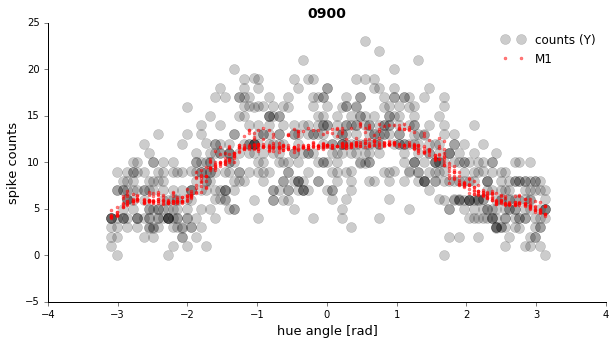

In [81]:
plt.figure(figsize=(10,5))
plt.title(params['selected_neuron'], {'fontsize': 14})

plt.plot(features_art['hue'], Yart[selected_neuron] + 0.01*np.random.normal(size=np.size(features_art['hue'])),
         'k.', alpha=0.2, markersize=20)

models_for_plot = ['M1']
colors = ['r','g','k','b']
for i, model in enumerate(models_for_plot):
    plt.plot(features_art['hue'], Models_art[model]['Yt_hat'], '.', color=colors[i], alpha = 0.5)
    
plt.xlabel('hue angle [rad]')
plt.ylabel('spike counts')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')

plt.legend(['counts (Y)'] + models_for_plot, frameon=False)
plt.show()

In [270]:
def plot_predicted_vs_counts(models_for_plot = models_for_plot, Y = Yart, models = Models_art, 
                             title = params['selected_neuron'],
                             colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E', '#FF07CD']):
    
    plt.title(title)

    unique_counts = np.unique(Y[selected_neuron])

    for i, model in enumerate(models_for_plot):

        if len(models_for_plot)==1:
            plt.plot(Y[selected_neuron] + 0.2*np.random.normal(size=np.size(Y[selected_neuron])),
                 models[model]['Yt_hat'], 
                 'k.', alpha=0.05, markersize=20)

        meanYhat = list()
        semYhat = list()

        for npks in unique_counts:
            loc = np.where(Y[selected_neuron]==npks)[0]
            meanYhat.append(np.mean(models[model]['Yt_hat'][loc]))
            semYhat.append(np.std(models[model]['Yt_hat'])/np.sqrt(len(loc)))

        plt.plot(np.unique(Y[selected_neuron]), meanYhat, '.', color=colors[i],  ms=15, alpha=0.9)
        #plt.plot(np.unique(Y[selected_neuron]), meanYhat, '-', color=colors[i],  ms=15, lw=0.3)
        plt.errorbar(np.unique(Y[selected_neuron]), meanYhat, fmt=None, yerr=np.array(semYhat), alpha=0.5, ecolor=colors[i])

    plt.ylabel('predicted (Y_hat)')
    plt.xlabel('spike counts (Y)')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    if len(models_for_plot)>1:
        plt.legend(models_for_plot , frameon=False, loc=0)
    else:
        plt.legend(['']+models_for_plot, frameon=False, loc=0)
        
# -----------------------------------------------------------------
def plot_model_vs_model(models_for_plot=models_for_plot, models=Models_art, title=params['selected_neuron']):
    max_val = np.max(models[models_for_plot[1]]['Yt_hat'])
    min_val = np.min(models[models_for_plot[1]]['Yt_hat'])
    plt.plot([min_val,max_val],[min_val,max_val], '-r', lw=0.6)
    plt.plot(models[models_for_plot[0]]['Yt_hat'], models[models_for_plot[1]]['Yt_hat'], 'k.', alpha=0.1, ms=10)

    plt.xlabel('model ' + models_for_plot[0])
    plt.ylabel('model ' + models_for_plot[1])
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    plt.title(title)
    plt.axis('equal')
    

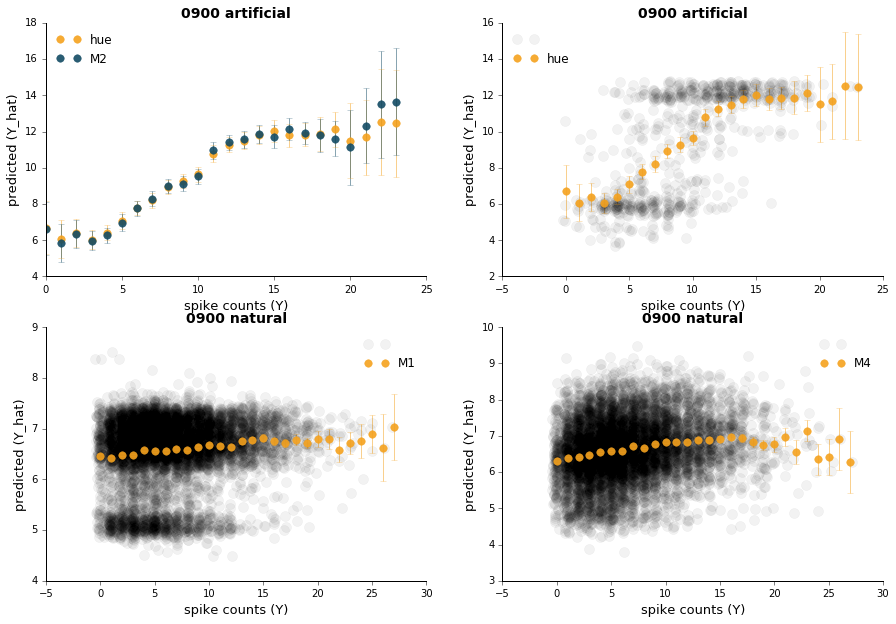

In [271]:
plt.figure(figsize=(15,10))
plt.subplot(221)
models_for_plot = ['hue', 'M2']
title = '%s artificial' % params['selected_neuron']
plot_predicted_vs_counts(models_for_plot=models_for_plot, Y=Yart, models=Models_art, title=title)

plt.subplot(222)
models_for_plot = ['hue']
title = '%s artificial' % params['selected_neuron']
plot_predicted_vs_counts(models_for_plot=models_for_plot, Y=Yart, models=Models_art, title=title)

plt.subplot(223)
models_for_plot = ['M1']
title = '%s natural' % params['selected_neuron']
plot_predicted_vs_counts(models_for_plot=models_for_plot, Y=Ynat, models=Models_nat, title=title)

plt.subplot(224)
models_for_plot = ['M4']
title = '%s natural' % params['selected_neuron']
plot_predicted_vs_counts(models_for_plot=models_for_plot, Y=Ynat, models=Models_nat, title=title)

plt.show()

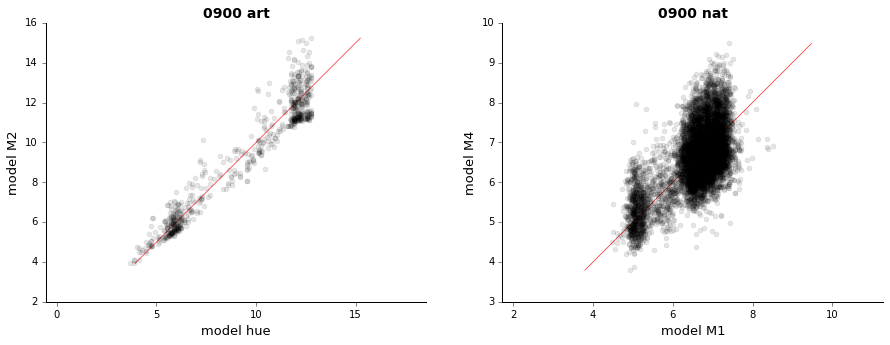

In [278]:
plt.figure(figsize=(15,5))
plt.subplot(121)
models_for_plot = ['hue','M2']
title = '%s art' % params['selected_neuron']
plot_model_vs_model(models_for_plot=models_for_plot, models=Models_art, title=title)

plt.subplot(122)
models_for_plot = ['M1','M4']
title = '%s nat' % params['selected_neuron']
plot_model_vs_model(models_for_plot=models_for_plot, models=Models_nat, title=title)

plt.show()

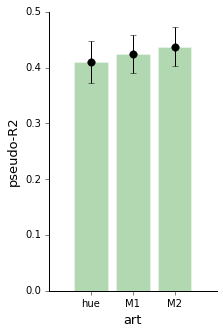

In [130]:
plt.figure(figsize=(3,5))

models_for_plot = ['hue', 'M1', 'M2']
plt.plot([-1, len(models_for_plot)],[0,0],'--k', alpha=0.4)

mean_pR2 = list()
sem_pR2 = list()


for model in models_for_plot:
    PR2_art = Models_art[model]['PR2_art']
    mean_pR2.append(np.mean(PR2_art))
    sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))

plt.bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.8, align='center', 
        ecolor='k', alpha=0.3, color='g', ec='w', yerr=np.array(sem_pR2), 
        tick_label=models_for_plot)
plt.plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=15)
#plt.xlim([-1,1])
#plt.ylim([-0.1, 1.0])

plt.xlabel('art')
plt.ylabel('pseudo-R2')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.show()

### nat

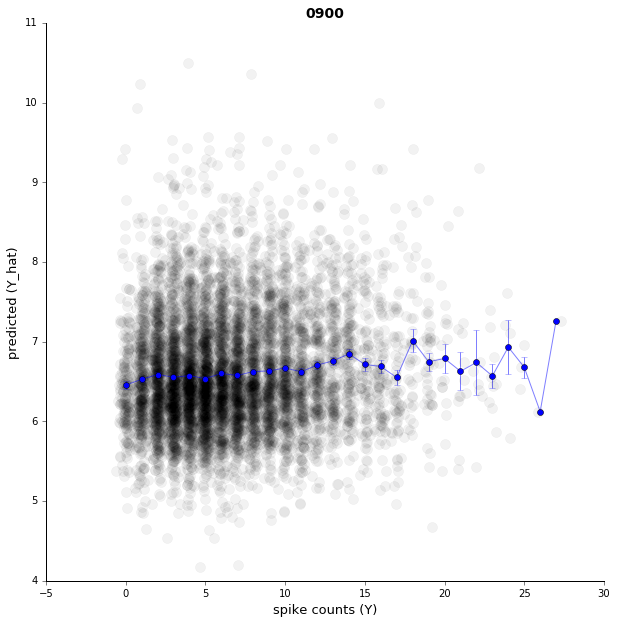

In [77]:
patch_n = 13

plt.figure(figsize=(10,10))
plt.title(params['selected_neuron'], {'fontsize': 14})

plt.plot(Ynat[selected_neuron] + 0.2*np.random.normal(size=np.size(Ynat[selected_neuron])),
         Yt_nat_hat[patch_n], 
         'k.', alpha=0.05, markersize=20)

meanYhat = list()
semYhat = list()
unique_counts = np.unique(Ynat[selected_neuron])

for i in unique_counts:
    loc = np.where(Ynat[selected_neuron]==i)[0]
    meanYhat.append(np.mean(Yt_nat_hat[patch_n][loc]))
    semYhat.append(np.std(Yt_nat_hat[patch_n][loc])/np.sqrt(len(loc)))

plt.errorbar(np.unique(Ynat[selected_neuron]),meanYhat,yerr=np.array(semYhat), alpha=0.5)
plt.plot(np.unique(Ynat[selected_neuron]),meanYhat,'bo')

plt.ylabel('predicted (Y_hat)')
plt.xlabel('spike counts (Y)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.show()

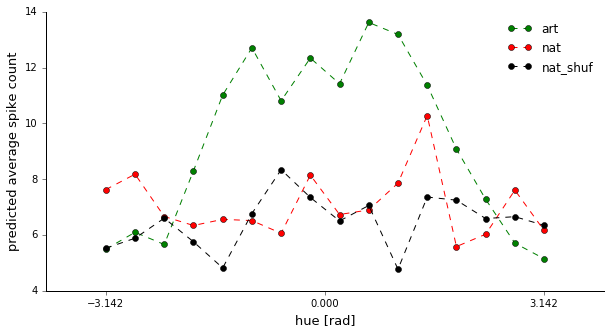

In [78]:
hue_line = np.linspace(-np.pi, np.pi, 16)
Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)
patch_n=10

Yline_nat_hat = V4pyutils.XGB_poisson(Xnat[patch_n], Ynat[selected_neuron], Xart_line)
Yline_nat_shuf_hat = V4pyutils.XGB_poisson(Xnat_shuf[patch_n], Ynat[selected_neuron], Xart_line)
Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

plt.figure(figsize=(10,5))
plt.plot(hue_line, Yline_art_hat,'o--g')
plt.plot(hue_line, Yline_nat_hat,'o--r')
plt.plot(hue_line, Yline_nat_shuf_hat,'o--k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.ylabel('predicted average spike count')
plt.xlabel('hue [rad]')
plt.xticks(np.linspace(-np.pi,np.pi,3))
plt.legend(['art', 'nat', 'nat_shuf'],frameon= False)
plt.show()

In [79]:
def run_synthetic(X, Y, hue_line, verbose = 1):
    Xart_line = V4pyutils.onehothue(hue_line, n_bins=16)
    Yline_hat = dict()
    
    for patch_n in X:
        if verbose:
            print 'running %d of %d' % (patch_n+1, len(X))
        Yline_hat[patch_n] = V4pyutils.XGB_poisson(X[patch_n], Y, Xart_line)
    
    return Yline_hat

In [80]:
Yline_nat_hat  = run_synthetic(Xnat, Ynat[selected_neuron], hue_line, verbose=0)
Yline_nat_shuf_hat  = run_synthetic(Xnat_shuf, Ynat[selected_neuron], hue_line, verbose=0)

Yline_art_hat = V4pyutils.XGB_poisson(Xart, Yart[selected_neuron], Xart_line)

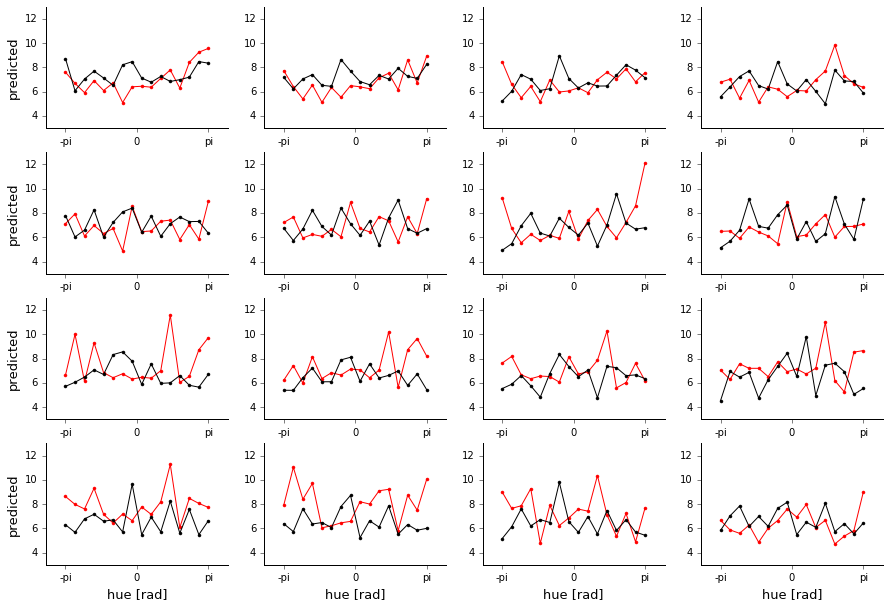

In [81]:
plt.figure(figsize=(15,10))
for patch_n in Yline_nat_hat:
    plt.subplot(4,4,patch_n+1)
    plt.plot(hue_line, Yline_nat_hat[patch_n],'.-r')
    plt.plot(hue_line, Yline_nat_shuf_hat[patch_n],'.-k')
    #plt.plot(hue_line, Yline_art_hat,'.-g')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    if patch_n%4==0:
        plt.ylabel('predicted')
    if patch_n>11:
        plt.xlabel('hue [rad]')
    plt.xticks(np.linspace(-np.pi,np.pi,3), ['-pi','0','pi'])
    #plt.legend(['art', 'nat', 'nat_shuf'],frameon= False)
    plt.ylim([3,13])
plt.show()

TypeError: list indices must be integers, not numpy.float64

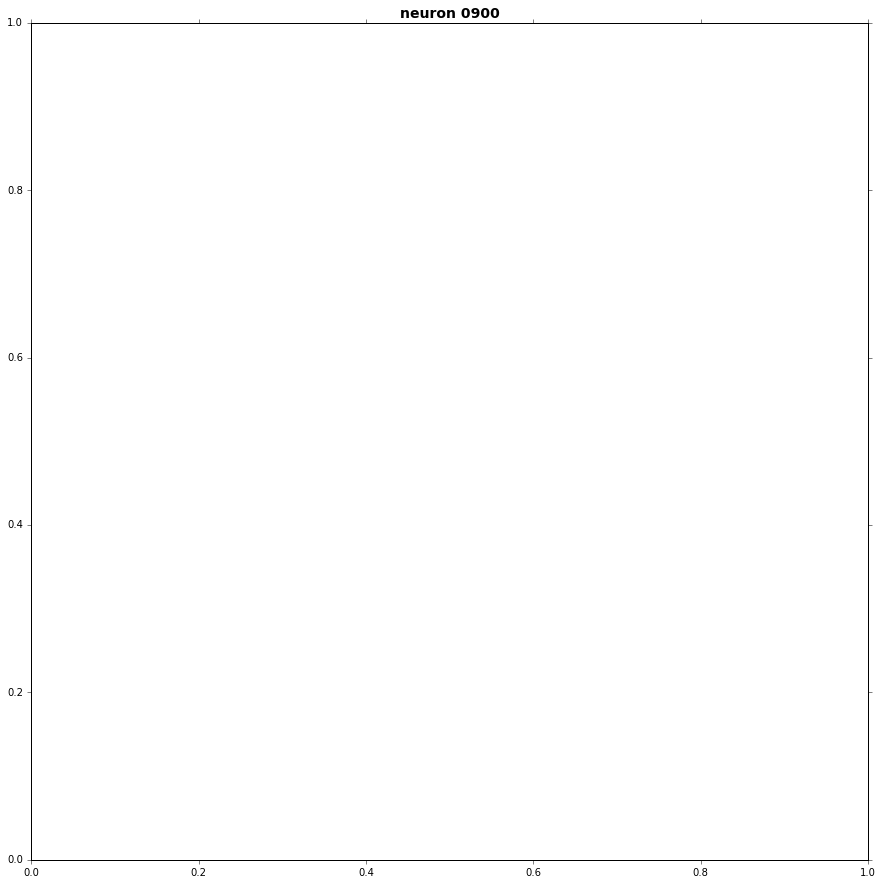

In [115]:
plt.figure(figsize=(15,15))
plt.title('neuron %s' % selected_neuron)
ylim = [-0.03,0.1]
for patch_n in PR2_nat:
    mean_pR2 = np.mean(PR2_nat[patch_n])
    sem_pR2 = np.std(PR2_nat[patch_n])/np.sqrt(np.size(PR2_nat[patch_n]))
    mean_pR2_shuf = np.mean(PR2_nat_shuf[patch_n])
    sem_pR2_shuf = np.std(PR2_nat_shuf[patch_n])/np.sqrt(np.size(PR2_nat_shuf[patch_n]))

    plt.subplot(4,4,patch_n+1)

    plt.bar([0,1], [mean_pR2, mean_pR2_shuf], 0.6, align='center', 
            ecolor='k', alpha=0.4, color=['r','k'], ec='w', yerr=1.96*np.array([sem_pR2, sem_pR2_shuf]), 
            tick_label=['nat','nat_shuf'])
    
    plt.plot([-1,1],[0,0],'--k', alpha=0.4)
    plt.plot([0,1], [mean_pR2, mean_pR2_shuf], '.', c='k', markersize=13)
    plt.xlim([-1,2])
   
    plt.ylim(ylim)
    
    ax = plt.gca()
    
    if patch_n>11:
        plt.xlabel('neuron id')
    if patch_n%4==0:
        plt.ylabel('pseudo-R2')
        plt.yticks([ylim[0],0,ylim[1]],[ylim[0],'0',ylim[1]])
    if patch_n%4>0:
        ax.spines['left'].set_visible(False)
        plt.yticks(ylim,['',''])
        plt.tick_params(axis='y', left='off')
     
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')

plt.show()